In [ ]:
#import drive to handle the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os # to handle files from drive
import pandas as pd # for reading and handling data
import openai # for using GPT API
import tiktoken as tokens #for counting the tokens
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix #matrices for evaluation
import matplotlib.pyplot as plt #for graphs
import seaborn as sns #for graphs too

In [ ]:
#API Key to link the model with the code
openai.api_key = "sk-proj-waN-w9vmtaUgdk0mPXvo5r4XVyKutHej_XNL_Iw9L-5pZgLR8nxCHuXJ4oz0g4cl0tcHN4FERMT3BlbkFJby3xnSZGm85O8rggsk6zr47YIdaBD4KUvbWF7QY180R2rX5G6nJgdCs5lve2-SQMyKmPq2N4A"

In [ ]:
# load the data from drive
file_path = '/content/drive/MyDrive/hhar_merged_half.csv'
data_set = pd.read_csv(file_path)

In [ ]:
# drop null values - choose some activites
data_set = data_set.dropna()
allowed_activities = ['stand', 'sit', 'bike', 'walk']
data_set = data_set[data_set['gt'].isin(allowed_activities)]

In [ ]:
#show the balance of the selected activities
activity_counts = data_set['gt'].value_counts()
print("Activity counts:\n", activity_counts)
balance_ratio = activity_counts.min() / activity_counts.max()
print("Balance ratio:", balance_ratio)


Activity counts:
 gt
walk     141672
sit      128915
stand    113094
bike     104706
Name: count, dtype: int64
Balance ratio: 0.7390733525326105


In [ ]:
# prepare the values for the window
sample_rate = 50 #hz
window_duration = 2.56 #s
window_size = int(sample_rate * window_duration)  # number of rows per window
overlap = window_size // 2  #50% overlapping

axis_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']  # sensors columns


In [ ]:
# set the window
windows = [] #to store all windows
true_labels = [] #to store the true labels

for i in range(0, len(data_set), overlap):  # loop through the dataset
    window = data_set.iloc[i:i+window_size]

    # take sensor readings as lists
    acc_x = window['acc_x'].tolist()
    acc_y = window['acc_y'].tolist()
    acc_z = window['acc_z'].tolist()
    gyro_x = window['gyro_x'].tolist()
    gyro_y = window['gyro_y'].tolist()
    gyro_z = window['gyro_z'].tolist()


  #add the windows and th the labels
    windows.append([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])
    true_labels.append(window['gt'].mode()[0])  #most frequent label in the window

#count the number of windows with overlapping
num_windows = len(windows)
print(f"Number of windows: {num_windows}")


Number of windows: 7630


In [ ]:
# make prompt
def simple_prompt(window_values):
    categories = ", ".join(['stand', 'sit', 'bike', 'walk'])
    acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z = window_values

    prompt = f"""
### Instruction:
Instruction: You are an expert of IMU-based human activity analysis
Question: The IMU data is collected from a mobile phone attached to the user's body with a sampling rate of 50 Hz and overlapping 50%. The IMU data is given in the IMU coordinate frame. The three-axis accelerations recording is given below.
x-axis: {acc_x}
y-axis: {acc_y}
z-axis: {acc_z}
The three-axis angular velocities recording is given below.
x-axis: {gyro_x}
y-axis: {gyro_y}
z-axis: {gyro_z}
The person's action belongs to one of the following categories: [{categories}].
Task: Based on the given IMU data, choose only one action form: [{categories}] that best represents the person's activity.
Answer with one word only (The chosen category)
### Response:
"""
    return prompt


In [ ]:
# count the tokens for each window
def count_tokens(text, model="gpt-5"):
    encoding = tokens.encoding_for_model(model)
    encoded_tokens = encoding.encode(text)
    return len(encoded_tokens)


In [ ]:
# classify a single window
def classify_window(window_values):
    prompt = simple_prompt(window_values)

    #count the number of tokens before the submit
    num_tokens = count_tokens(prompt)

    try:
        response = openai.chat.completions.create(
            model="gpt-5",
            messages=[{"role": "user", "content": prompt}]
        )
        label = response.choices[0].message.content.strip()
        return label , num_tokens
    except Exception as e:
        print(f"API Error: {e}")
        return "unknown" , num_tokens

In [ ]:
#implemntation
predictions_csv = "/content/drive/MyDrive/predictions_for_50%_overlapping.csv"

if os.path.exists(predictions_csv): #if the file already exits complete the process
    readTheFile = pd.read_csv(predictions_csv)
    start_index = len(readTheFile)
    pred_labels = readTheFile["prediction"].tolist()
    all_tokens = readTheFile["num_tokens"].tolist()
    print(f"Resuming from index {start_index}")
else: #or start form the begining
    start_index = 0
    pred_labels = []
    all_tokens = []
    print("Starting  predictions:")

batch_size = 50 #number of windows each batch

for i in range(start_index, len(windows), batch_size):
    batch_windows = windows[i:i+batch_size]

    # label and tokens for each window
    batch_preds = []
    batch_tokens = []

    for w in batch_windows:
        label, tokens_count = classify_window(w)
        batch_preds.append(label)
        batch_tokens.append(tokens_count)

    pred_labels.extend(batch_preds)
    all_tokens.extend(batch_tokens)

    header = not os.path.exists(predictions_csv) and i == 0
    pd.DataFrame({"window_values": batch_windows, "prediction": batch_preds , "num_tokens": batch_tokens}).to_csv(
        predictions_csv, mode="a", header=header, index=False
    )
    print(f"Processed batch {i} to {i+len(batch_windows)}, tokens per window: {batch_tokens}")

Resuming from index 7200
Processed batch 7200 to 7250, tokens per window: [5705, 5702, 5722, 5753, 5773, 5689, 5673, 5723, 5705, 5717, 5715, 5689, 5683, 5718, 5746, 5751, 5713, 5684, 5699, 5694, 5719, 5746, 5782, 5750, 5675, 5714, 5734, 5711, 5708, 5670, 5672, 5705, 5741, 5744, 5720, 5722, 5734, 5781, 5792, 5731, 5699, 5734, 5744, 5714, 5716, 5709, 5727, 5738, 5712, 5672]
Processed batch 7250 to 7300, tokens per window: [5643, 5684, 5763, 5781, 5740, 5701, 5718, 5761, 5748, 5762, 5738, 5682, 5666, 5649, 5642, 5647, 5711, 5727, 5688, 5739, 5733, 5706, 5695, 5684, 5698, 5699, 5718, 5721, 5734, 5737, 5734, 5701, 5685, 5701, 5718, 5720, 5731, 5729, 5686, 5680, 5733, 5713, 5711, 5755, 5744, 5729, 5720, 5758, 5770, 5758]
Processed batch 7300 to 7350, tokens per window: [5725, 5674, 5681, 5705, 5752, 5782, 5760, 5741, 5704, 5699, 5733, 5737, 5706, 5708, 5751, 5763, 5720, 5703, 5715, 5694, 5707, 5726, 5745, 5766, 5749, 5717, 5695, 5703, 5723, 5784, 5800, 5779, 5698, 5672, 5709, 5721, 5740, 573

In [ ]:
# evaluation
results = pd.read_csv(predictions_csv)

# take the true labels(array true label above) with the predections of the model
pred_labels = results["prediction"].tolist()

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, labels=allowed_activities, average='weighted')
recall = recall_score(true_labels, pred_labels, labels=allowed_activities, average='weighted')
F1= f1_score(true_labels, pred_labels, labels=allowed_activities, average='weighted')
cm = confusion_matrix(true_labels, pred_labels, labels=allowed_activities)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {F1:.4f}")
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=allowed_activities, columns=allowed_activities))


Accuracy: 0.4298
Weighted Precision: 0.4014
Weighted Recall: 0.4298
Weighted F1-score: 0.3163
Confusion Matrix:
       stand  sit  bike  walk
stand   1040   47   130   551
sit     1379   70   137   428
bike       7    1    18  1588
walk       0    0     7  2151


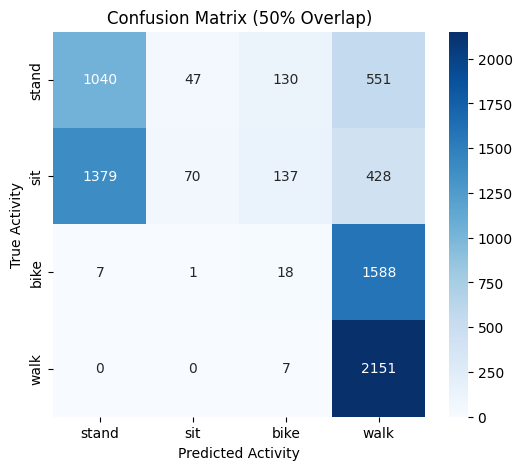

In [ ]:
# gragh for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=allowed_activities,
            yticklabels=allowed_activities)
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.title("Confusion Matrix (50% Overlap)")
plt.show()


In [ ]:
#count the averge of tokens per window and the total
average_tokens = results["num_tokens"].mean()
total_tokens = results["num_tokens"].sum()

print("Average tokens per window:", average_tokens)
print("Total tokens used:", total_tokens)


Average tokens per window: 5663.3509829619925
Total tokens used: 43211368


In [ ]:
#first add true labels to the file to for the next step
addToTheFile= pd.read_csv(predictions_csv)
addToTheFile["true_label"] = true_labels
addToTheFile.to_csv(predictions_csv, index=False)


In [ ]:
#show the labels for all window in true-labels and prediction
results = pd.read_csv(predictions_csv)

true_labels = results["true_label"].tolist()
pred_labels = results["prediction"].tolist()


def windows_segments(labels):
    segments = [] #to store all segments
    start = 0 # start point for each segments
    current_Activity = labels[0]

    for i in range(1, len(labels)):
        if labels[i] != current_Activity: #if the current activity is not the same activity in the true and preditction windows
            segments.append((start, i - 1, current_Activity)) #add the segmants to the array
            start = i #change the start of the next segments
            current_Activity = labels[i] #change the activity to the next one

    segments.append((start, len(labels) - 1, current_Activity)) #loop to add more the last segment for each activity
    return segments


true_segments = windows_segments(true_labels)
pred_segments = windows_segments(pred_labels)

print("\n True Activity Segments ")
for seg in true_segments:
    print(f"From window {seg[0]} to {seg[1]} : {seg[2]}") # From window 7283 to 7283 : bike

print("\nPredicted Activity Segments ")
for seg in pred_segments:
    print(f"From window {seg[0]} to {seg[1]} : {seg[2]}")




 True Activity Segments 
From window 0 to 157 : bike
From window 158 to 420 : sit
From window 421 to 652 : stand
From window 653 to 866 : walk
From window 867 to 1112 : bike
From window 1113 to 1288 : sit
From window 1289 to 1461 : stand
From window 1462 to 1733 : walk
From window 1734 to 1869 : bike
From window 1870 to 2086 : sit
From window 2087 to 2258 : stand
From window 2259 to 2495 : walk
From window 2496 to 2656 : bike
From window 2657 to 2874 : sit
From window 2875 to 3097 : stand
From window 3098 to 3363 : walk
From window 3364 to 3584 : bike
From window 3585 to 3817 : sit
From window 3818 to 4039 : stand
From window 4040 to 4313 : walk
From window 4314 to 4473 : bike
From window 4474 to 4634 : sit
From window 4635 to 4791 : stand
From window 4792 to 4986 : walk
From window 4987 to 5150 : bike
From window 5151 to 5388 : sit
From window 5389 to 5605 : stand
From window 5606 to 5878 : walk
From window 5879 to 6049 : bike
From window 6050 to 6310 : sit
From window 6311 to 6471 :

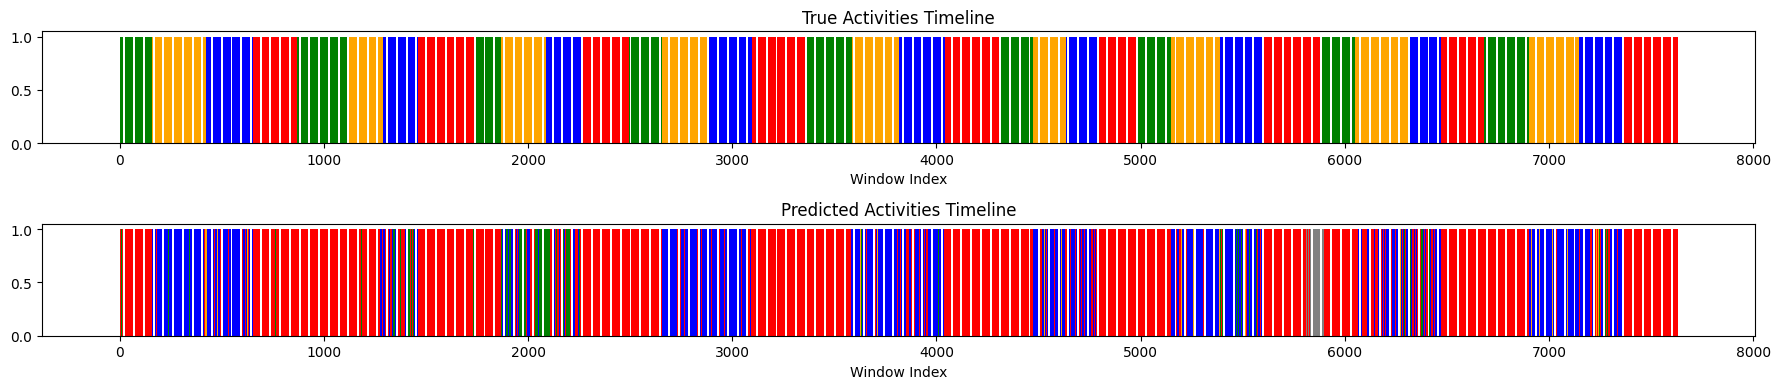

In [ ]:
#timeline gragh for the segments of windows (true labels - presctions )

activities = ['stand', 'sit', 'bike', 'walk']
colors = {
    'stand': 'blue',
    'sit': 'orange',
    'bike': 'green',
    'walk': 'red',
    None: 'gray'
}
pred_labels = [p if p in activities else None for p in pred_labels] #for unknown predection

plt.figure(figsize=(18, 4))

plt.subplot(2, 1, 1)
i = 0
for activity in true_labels:
    plt.bar(i, 1, color=colors[activity])
    i += 1

plt.title("True Activities Timeline")
plt.xlabel("Window Index")


plt.subplot(2, 1, 2)
i = 0
for activity in pred_labels:
    plt.bar(i, 1, color=colors[activity])
    i += 1

plt.title("Predicted Activities Timeline")
plt.xlabel("Window Index")

plt.tight_layout() #make the the graphs coherent
plt.show()
